<a href="https://colab.research.google.com/github/suhaodatascichem/Soybean-Meal-price/blob/main/Soybean%20meal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import required libraries

In [1]:
# required libraries
import pandas as pd
import numpy as np
import datetime as dt

# for plots
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.preprocessing import MinMaxScaler
import math, time
from sklearn.metrics import mean_squared_error
import time
from sklearn.metrics import mean_squared_error

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Read Data

In [4]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
files = '/content/drive/MyDrive/Soybean meal price/US Soybean Meal Futures Historical Data-daily.csv'
df_raw = pd.read_csv(files)


In [6]:
startdate = df_raw['Date'].min()
print('startdate is '+ startdate)


startdate is 01/01/2020


In [7]:
df_raw.head(1)

,Date,Price,Open,High,Low,Vol.,Change %
0,12/27/2024,310.5,315.2,315.6,310.1,NaN,-1.40%


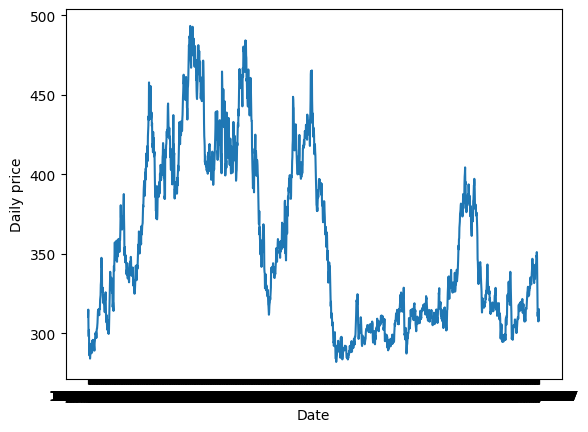

<Figure size 3200x200 with 0 Axes>

In [8]:
plt.plot(df_raw['Date'], df_raw["Price"])
plt.xlabel("Date")
plt.ylabel("Daily price")
plt.figure(figsize=(32,2))
plt.show()

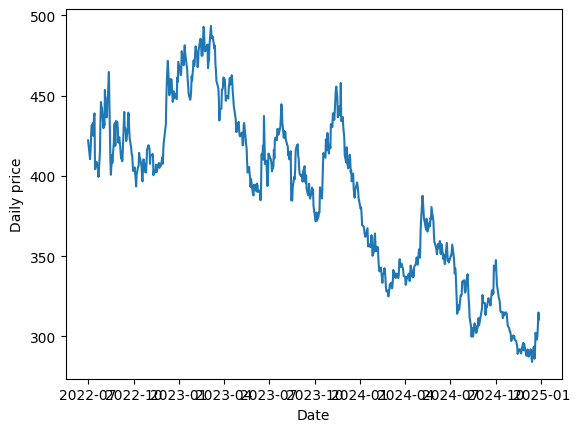

<Figure size 3200x200 with 0 Axes>

In [9]:
df_raw['Date'] = pd.to_datetime(df_raw['Date'])
# df = df_raw[(df_raw['Date'] > '2019-12-31') & (df_raw['Date'] < '2022-12-31')]
df = df_raw[df_raw['Date'] > '2022-06-30']
plt.plot(df['Date'], df["Price"])
plt.xlabel("Date")
plt.ylabel("Daily price")
plt.figure(figsize=(32,2))
plt.show()

In [10]:
# min-max nomalization
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
df[['Price']] = scaler.fit_transform(df[['Price']])

<ipython-input-10-bcbce0cf0b0b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['Price']] = scaler.fit_transform(df[['Price']])


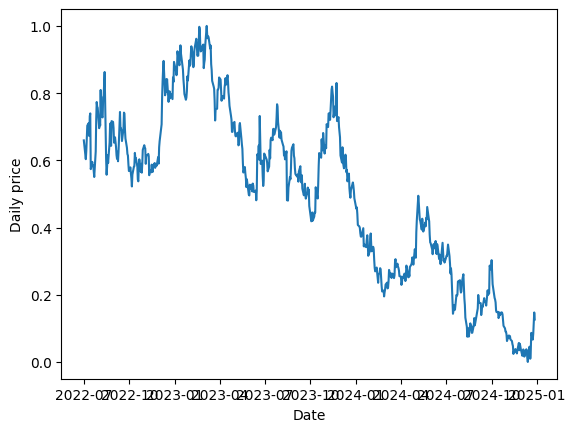

<Figure size 3200x200 with 0 Axes>

In [11]:
plt.plot(df['Date'], df["Price"])
plt.xlabel("Date")
plt.ylabel("Daily price")
plt.figure(figsize=(32,2))
plt.show()

# LSTM only consider the period after covid, 2022-07 onwards

## Data Prep

In [12]:
#Function to perform the train test split on the df based on the desired window_size (ws)
def train_test_prep(series, x_variables, y_variables,  window_size, test_size):
  # series should be a numpy series
  x_series = series[x_variables].to_numpy()
  y_series = series[y_variables].to_numpy()

  x_data = []
  y_data = []
  for i in range(len(x_series) - window_size):
    x_data.append(x_series[i: i+window_size])
    y_data.append(y_series[i+window_size])
  x_data = np.array(x_data)
  y_data = np.array(y_data)

  train_size = x_data.shape[0] - test_size

  train_x = x_data[:train_size, :,:]
  train_y = y_data[:train_size, :]

  test_x = x_data[train_size:train_size+test_size, :,:]
  test_y = y_data[train_size:train_size+test_size:, :]

  return [train_x, train_y, test_x, test_y]

In [13]:
ws = 30
test_size = 180

In [14]:
x_train, y_train, x_test, y_test = train_test_prep(df, ["Price"],["Price"], ws,test_size)

In [15]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((431, 30, 1), (180, 30, 1), (431, 1), (180, 1))

In [16]:
#Function to obtain train, test data as tensors for torch
def array_to_tensor(x_train, x_test, y_train, y_test):
  x_train_torch = torch.from_numpy(x_train).type(torch.Tensor).cuda()
  x_test_torch = torch.from_numpy(x_test).type(torch.Tensor).cuda()
  y_train_torch = torch.from_numpy(y_train).type(torch.Tensor).cuda()
  y_test_torch = torch.from_numpy(y_test).type(torch.Tensor).cuda()
  return x_train_torch, x_test_torch, y_train_torch, y_test_torch

In [17]:
x_train_torch, x_test_torch, y_train_torch, y_test_torch = array_to_tensor(x_train, x_test, y_train, y_test)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
x_train_torch.shape, x_test_torch.shape, y_train_torch.shape, y_test_torch.shape

# Baseline model

In [ ]:
# base line model that uses the previous time stamp's demand as the predicted demand

#function for baseline model
def baseline_rmse(df, ws, y_train_data, column_name):
  y_base_test = np.array(df[column_name][ws+y_train.shape[0]-1:-1],dtype=np.float32)
  y_base_label = np.array(df[column_name][ws+y_train.shape[0]:],dtype=np.float32)

  print(y_base_test, y_base_label)
  rmse_loss_test = np.sqrt(mean_squared_error(y_base_test, y_base_label))
  return rmse_loss_test

In [ ]:
baseline_rmse(df, ws, y_train, 'Price')

# LSTM Model Architecture


In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, num_epochs, dropout_rate):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().cuda()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().cuda()
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
def build_lstm_model(input_dim, hidden_dim, num_layers, output_dim, num_epochs, dropout_rate):
  model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers, num_epochs=num_epochs, dropout_rate=dropout_rate)
  model = model.cuda()
  cr = torch.nn.MSELoss(reduction='mean')
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  return model, cr, optimizer

In [ ]:
#General Parameters
#input_dim = 1
#output_dim = 1
#num_layers = 2
#hidden_dim = 50
#num_epochs = 100
#dropout_rate = 0.3

# Train LSTM Model

In [ ]:
def train_model(model, cr, optimizer, x_train_torch, y_train_torch, x_test_torch, y_test_torch, num_epochs):
  torch.manual_seed(42)
  torch.cuda.manual_seed(42)
  torch.cuda.manual_seed_all(42)
  np.random.seed(42)
  torch.backends.cudnn.deterministic = True

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)
  start_time = time.time()
  lstm = []


  for t in range(num_epochs):
    model.train()
    y_train_pred = model(x_train_torch)
    loss = cr(y_train_pred, y_train_torch)
    train_hist[t] = loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
      y_test_pred = model(x_test_torch)
      loss = cr(y_test_pred, y_test_torch)
      test_hist[t] = loss.item()
      #print("Epoch ", t, "train MSE: ", train_hist[t], "Test MSE:", test_hist[t])

  training_time = time.time()-start_time
  #print("Training time: {}".format(training_time))
  return y_train_pred, y_test_pred

# Get Train Test RMSE



In [ ]:
def get_RMSE(y_train_pred, y_train_torch , type='Train'):
  # invert predictions
  y_train_pred = y_train_pred.cpu().detach().numpy()
  y_train_final = y_train_torch.cpu().detach().numpy()

  # calculate root mean squared error
  trainScore = math.sqrt(mean_squared_error(y_train_final[:,0], y_train_pred[:,0]))
  print(f"{type} RMSE: ",trainScore)

  return trainScore

#Model parameters fine tuneing

In [ ]:
# Function to vary the number of layers and hidden dimensions, and epochs to find the combination with the best RMSE
def model_tuning(x_train_torch, y_train_torch, x_test_torch, y_test_torch, input_dim, output_dim):
  torch.manual_seed(42)
  torch.cuda.manual_seed(42)
  torch.cuda.manual_seed_all(42)
  np.random.seed(42)
  torch.backends.cudnn.deterministic = True
  testscore = 0
  nl = 0
  hd = 0
  epochs = 0
  summary = []
  for num_epochs in [100, 200, 300, 400]:
    for num_layers in [2, 3, 4, 5]:
      for hidden_dim in [25, 50, 75, 100]:
        model, cr, optimizer = build_lstm_model(input_dim, hidden_dim, num_layers, output_dim, num_epochs,dropout_rate)
        y_train_pred, y_test_pred = train_model(model, cr, optimizer, x_train_torch, y_train_torch, x_test_torch, y_test_torch, num_epochs)
        train_score = get_RMSE(y_train_torch, y_train_pred, type='Train')
        # test_score = get_test_rmse(x_test_torch, y_test_torch, model, ws, test_size)
        test_score = get_RMSE(y_test_torch, y_test_pred, type='Test')
        print(", Number of layers: ", num_layers, ", Hidden dimensions: ", hidden_dim, ", Number of Epochs:", num_epochs)
        summary.append({
            'Number of layers': num_layers,
            'Hidden dimensions': hidden_dim,
            'Number of Epochs': num_epochs,
            'Train RMSE': train_score,
            'Test RMSE': test_score
        })

        if test_score < testscore or testscore == 0 :
          testscore = test_score
          nl = num_layers
          hd = hidden_dim
          epochs = num_epochs
  print("Optimum Number of layers:", nl, "Optimum Hidden dimensions:", hd, "Optimum Number of Epochs:",epochs,"Test RMSE:", testscore)
  return nl, hd, epochs, summary

In [ ]:
nl, hd, epochs, summary = model_tuning(x_train_torch, y_train_torch, x_test_torch, y_test_torch, input_dim, output_dim)

In [ ]:
summary_df = pd.DataFrame(summary)
summary_df

In [ ]:
train_min_idx = summary_df['Train RMSE'].idxmin()
test_min_idx = summary_df['Test RMSE'].idxmin()

train_min_row = summary_df.loc[train_min_idx]
test_min_row = summary_df.loc[test_min_idx]

# Display the results
print("Row with the smallest Train Score: ", train_min_row)
#print(train_min_row)
print("\nRow with the smallest Test Score: ", test_min_row)

In [ ]:
input_dim = 1
hidden_dim = 75
num_layers = 5
output_dim = 1
num_epochs = 400
dropout_rate = 0.3
model, cr, optimizer = build_lstm_model(input_dim, hidden_dim, num_layers, output_dim, num_epochs, dropout_rate)
y_train_pred, y_test_pred = train_model(model, cr, optimizer, x_train_torch, y_train_torch, x_test_torch, y_test_torch, num_epochs)


In [ ]:
y_train.shape, y_train_pred.shape

In [ ]:
#reverse normalization
y_train = scaler.inverse_transform(y_train)
y_train_pred = scaler.inverse_transform(y_train_pred.cpu().detach().numpy())
y_test = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_test_pred.cpu().detach().numpy())

In [ ]:
y_test_pred[1]

In [ ]:
original_train = pd.DataFrame(y_train)
predict_test = pd.DataFrame(y_test_pred)
original_test = pd.DataFrame(y_test)


In [ ]:
original_train.head()

In [59]:
import seaborn as sns
sns.set_style("darkgrid")

fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace=0.2, wspace=0.2)


ax = sns.lineplot(x = original_train.index, y = original_train.loc[1], label="Data", color='blue')
#ax = sns.lineplot(x = predict_train.index, y = predict[0], label="LSTM", color='red')
ax = sns.lineplot(x = original_test.index, y = original_test.loc[1], label="Data", color='yellow')
ax = sns.lineplot(x = predict_test.index, y = predict_test, label="LSTM", color='green')
ax.set_title('SBM price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


#plt.subplot(1, 2, 2)
#ax = sns.lineplot(data=hist, color='royalblue')
#ax.set_xlabel("Epoch", size = 14)
#ax.set_ylabel("Loss", size = 14)
#ax.set_title("Training Loss", size = 14, fontweight='bold')
#fig.set_figheight(6)
#fig.set_figwidth(16)

KeyError: 1

<Figure size 1200x1200 with 0 Axes>

## Create model


In [ ]:
def get_best_model(input_dim, hidden_dim, num_layers, output_dim, x_train_torch, y_train_torch, x_test_torch, y_test_torch, num_epochs, ws, test_size):
  model, cr, optimizer = build_lstm_model(input_dim, hidden_dim, num_layers, output_dim, num_epochs)
  y_train_pred, y_test_pred = train_model(model, cr, optimizer, x_train_torch, y_train_torch, x_test_torch, y_test_torch, num_epochs)
  train_score = get_train_RMSE(y_train_pred, y_train_torch)
  test_score = get_test_rmse(x_test_torch, y_test_torch, model, ws, test_size)
  return train_score, test_score, model

#Get x months ahead worth of predictions

In [ ]:
#Function to take in the correct window of data and generate 5 months ahead predictions
def forecast_x_months(ws, df, model, months_ahead, column_name):
  predictions = []
  current_window = df[[column_name]][-ws:].to_numpy()
  current_window = current_window.reshape(1,ws,1)
  for i in range(months_ahead):
    current_window_torch = torch.from_numpy(current_window).type(torch.Tensor).cuda()
    pred = model(current_window_torch)
    pred = pred.cpu().detach().numpy()
    predictions.append(pred)
    current_window_torch = current_window_torch.cpu().detach().numpy()
    current_window = np.append(current_window, pred)
    current_window = current_window[-ws:].reshape(1,ws,1)
  predictions = scale.inverse_transform(np.array(predictions).reshape(months_ahead,1))
  return predictions

In [ ]:
#Function to take in the correct window of data and generate 6 months ahead predictions
def forecast_x_days(ws, df, model, months_ahead):
  predictions = []
  current_window = df['DailySalesQuantity'][-ws:].to_numpy()
  current_window = current_window.reshape(1,ws,1)
  for i in range(months_ahead):
    current_window_torch = torch.from_numpy(current_window).type(torch.Tensor).cuda()
    pred = model(current_window_torch)
    pred = pred.cpu().detach().numpy()
    predictions.append(pred)
    current_window_torch = current_window_torch.cpu().detach().numpy()
    current_window = np.append(current_window, pred)
    current_window = current_window[-ws:].reshape(1,ws,1)
  predictions = scale.inverse_transform(np.array(predictions).reshape(months_ahead,1))
  return predictions

In [ ]:
predictions = forecast_x_days(ws, df, model, test_size)
predictions

NameError: name 'model' is not defined

In [ ]:
  #Detach all torch tensors
  x_train_torch = x_train_torch.cpu().detach().numpy()
  x_test_torch = x_test_torch.cpu().detach()
  y_train_torch = y_train_torch.cpu().detach().numpy()
  y_test_torch = y_test_torch.cpu().detach().numpy()